In [1]:
# Import necessary libraries

!pip install scikeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,  KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.interpolate import griddata

In [2]:
student_vle = pd.read_csv('studentVle.csv', sep='\t', encoding="utf-8")

In [3]:
student_info = pd.read_csv('studentInfo.csv')
student_vle = pd.read_csv('studentVle.csv',encoding="utf-8")

In [4]:
# Display basic information about each dataset
print("Student Info:")
print(student_info.head())

Student Info:
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N 

In [5]:
num_students = student_info.shape[0]
print(f"👥 Number of students: {num_students}")

👥 Number of students: 32593


In [6]:
print("\nStudent VLE:")
print(student_vle.head())


Student VLE:
  code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1


In [7]:
sum_clicks = student_vle.groupby(['id_student', 'code_module', 'code_presentation'])['sum_click'].sum().reset_index()
sum_clicks.rename(columns={'sum_click': 'sum_clicks'}, inplace=True)

interaction = student_vle.groupby(['id_student', 'code_module', 'code_presentation'])['id_site'].nunique().reset_index()
interaction.rename(columns={'id_site': 'interaction'}, inplace=True)

data = student_info.merge(sum_clicks, on=['id_student', 'code_module', 'code_presentation'], how='left')
data = data.merge(interaction, on=['id_student', 'code_module', 'code_presentation'], how='left')

data[['sum_clicks', 'interaction']] = data[['sum_clicks', 'interaction']].fillna(0)

In [8]:
# Convert 'final_result' to a dichotomous variable1 if Pass or Distinction, 0 if Fail or Withdrawn
data['final_result_binary'] = data['final_result'].map({'Pass': 1, 'Distinction': 1, 'Fail': 0, 'Withdrawn': 0})
data.drop(columns=['final_result'], inplace=True)

In [9]:
num_students_data = data.shape[0]
print(f"👥 Number of students: {num_students_data}")

👥 Number of students: 32593


In [10]:
print(data.head())

  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability  sum_clicks  interaction  final_result_binary  
0              240          N       934.0         55.0  

As seen, "highest education" is categorical so we should apply ordinal encoder to order the values from largest to smallest

In [11]:
# Obtain unique values of the column 'highest_education'
unique_education_levels = student_info['highest_education'].unique()

# Print unique values
print("Valores únicos en 'highest_education':")
print(unique_education_levels)

Valores únicos en 'highest_education':
['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']


In [12]:
# Obtain unique values for the column 'imd_band'
unique_age_band = student_info['age_band'].unique()

# Print unique values
print("Valores únicos en 'age_band':")
print(unique_age_band)

Valores únicos en 'age_band':
['55<=' '35-55' '0-35']


In [13]:
#Verify  missing values
print("\n🔎 Missing Values After Cleaning:")
print(data.isnull().sum())


🔎 Missing Values After Cleaning:
code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
sum_clicks                 0
interaction                0
final_result_binary        0
dtype: int64


In [14]:
data.loc[data['imd_band'].isnull(), 'imd_band'] = data.groupby('region')['imd_band'].transform('first')
print(data.head())

  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability  sum_clicks  interaction  final_result_binary  
0              240          N       934.0         55.0  

In [15]:
#Verify  missing values
print("\n🔎 Missing Values After Cleaning:")
print(data.isnull().sum())


🔎 Missing Values After Cleaning:
code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
sum_clicks              0
interaction             0
final_result_binary     0
dtype: int64


In [16]:
# Apply Ordinal Encoding to 'age_band'
ordinal_encoder = OrdinalEncoder(categories=[['0-35', '35-55', '55<=']])
data['age_band_encoded'] = ordinal_encoder.fit_transform(data[['age_band']])
data.drop(columns=['age_band'], inplace=True)

# Apply Ordinal Encoding to 'highest education'
ordinal_encoder = OrdinalEncoder(categories=[[
    'No Formal quals',               # 0 → No formal education
    'Lower Than A Level',             # 1 → Less than A-Level
    'A Level or Equivalent',          # 2 → A level or equivalent
    'Post Graduate Qualification',    # 3 → Post gradate
    'HE Qualification'                # 5 → Highest Education
]])
data['highest_education_encoded'] = ordinal_encoder.fit_transform(data[['highest_education']])
data.drop(columns=['highest_education'], inplace=True)


#Apply One-Hot Encoding to categorical variables
categorical_features = ['gender', 'region', 'disability']
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = pd.DataFrame(one_hot_encoder.fit_transform(data[categorical_features]),
                                columns=one_hot_encoder.get_feature_names_out(categorical_features),
                                index=data.index)

# Merge encoded features and drop original categorical columns
data = pd.concat([data.drop(columns=categorical_features), encoded_features], axis=1)

In [17]:

# Apply Ordinal Encoding to 'imd_band'
ordinal_encoder = OrdinalEncoder(categories=[['0-10%', '10-20','20-30%', '30-40%','40-50%', '50-60%' ,'60-70%','70-80%', '80-90%','90-100%' ]])
data['imd_band_encoded'] = ordinal_encoder.fit_transform(data[['imd_band']])
data.drop(columns=['imd_band'], inplace=True)

In [18]:
print(data.head())

  code_module code_presentation  id_student  num_of_prev_attempts  \
0         AAA             2013J       11391                     0   
1         AAA             2013J       28400                     0   
2         AAA             2013J       30268                     0   
3         AAA             2013J       31604                     0   
4         AAA             2013J       32885                     0   

   studied_credits  sum_clicks  interaction  final_result_binary  \
0              240       934.0         55.0                    1   
1               60      1435.0         84.0                    1   
2               60       281.0         22.0                    0   
3               60      2158.0         82.0                    1   
4               60      1034.0         66.0                    1   

   age_band_encoded  highest_education_encoded  ...  \
0               2.0                        4.0  ...   
1               1.0                        4.0  ...   
2          

In [19]:
data.to_csv("data.csv", index=False)

# **DESCRIPTIVE ANALYSIS**

In [20]:
#Summary Statistics

print("\n Summary Statistics for Numerical Variables:")
print(data.describe())


 Summary Statistics for Numerical Variables:
         id_student  num_of_prev_attempts  studied_credits    sum_clicks  \
count  3.259300e+04          32593.000000     32593.000000  32593.000000   
mean   7.066877e+05              0.163225        79.758691   1215.141257   
std    5.491673e+05              0.479758        41.071900   1692.604449   
min    3.733000e+03              0.000000        30.000000      0.000000   
25%    5.085730e+05              0.000000        60.000000    142.000000   
50%    5.903100e+05              0.000000        60.000000    602.000000   
75%    6.444530e+05              0.000000       120.000000   1585.000000   
max    2.716795e+06              6.000000       655.000000  24139.000000   

        interaction  final_result_binary  age_band_encoded  \
count  32593.000000         32593.000000      32593.000000   
mean      60.150830             0.472034          0.302672   
std       55.898555             0.499225          0.473628   
min        0.000000  

Summary of the most important variables

In [21]:
key_vars = [
    'studied_credits', 'sum_clicks', 'interaction', 'final_result_binary',
    'age_band_encoded', 'highest_education_encoded', 'imd_band_encoded',
    'num_of_prev_attempts', 'disability_Y'
]

summary = data[key_vars].describe().T
display(summary)

,count,mean,std,min,25%,50%,75%,max
studied_credits,32593.0,79.758691,41.071900,30.0,60.0,60.0,120.0,655.0
sum_clicks,32593.0,1215.141257,1692.604449,0.0,142.0,602.0,1585.0,24139.0
interaction,32593.0,60.150830,55.898555,0.0,19.0,46.0,86.0,413.0
final_result_binary,32593.0,0.472034,0.499225,0.0,0.0,0.0,1.0,1.0
age_band_encoded,32593.0,0.302672,0.473628,0.0,0.0,0.0,1.0,2.0
highest_education_encoded,32593.0,1.874850,1.010325,0.0,1.0,2.0,2.0,4.0
imd_band_encoded,32593.0,4.255515,2.783772,0.0,2.0,4.0,7.0,9.0
num_of_prev_attempts,32593.0,0.163225,0.479758,0.0,0.0,0.0,0.0,6.0
disability_Y,32593.0,0.097076,0.296066,0.0,0.0,0.0,0.0,1.0


In [22]:
# Calcular la matriz de correlaciones
correlation_matrix = data[key_vars].corr().round(2)

display(correlation_matrix)

,studied_credits,sum_clicks,interaction,final_result_binary,age_band_encoded,highest_education_encoded,imd_band_encoded,num_of_prev_attempts,disability_Y
studied_credits,1.00,-0.04,-0.02,-0.14,-0.07,0.01,-0.04,0.18,0.05
sum_clicks,-0.04,1.00,0.76,0.48,0.14,0.09,0.09,-0.07,-0.04
interaction,-0.02,0.76,1.00,0.53,0.11,0.12,0.11,-0.06,-0.03
final_result_binary,-0.14,0.48,0.53,1.00,0.07,0.13,0.13,-0.11,-0.06
age_band_encoded,-0.07,0.14,0.11,0.07,1.00,0.13,0.07,0.01,-0.02
highest_education_encoded,0.01,0.09,0.12,0.13,0.13,1.00,0.12,-0.04,-0.08
imd_band_encoded,-0.04,0.09,0.11,0.13,0.07,0.12,1.00,-0.04,-0.07
num_of_prev_attempts,0.18,-0.07,-0.06,-0.11,0.01,-0.04,-0.04,1.00,0.05
disability_Y,0.05,-0.04,-0.03,-0.06,-0.02,-0.08,-0.07,0.05,1.00


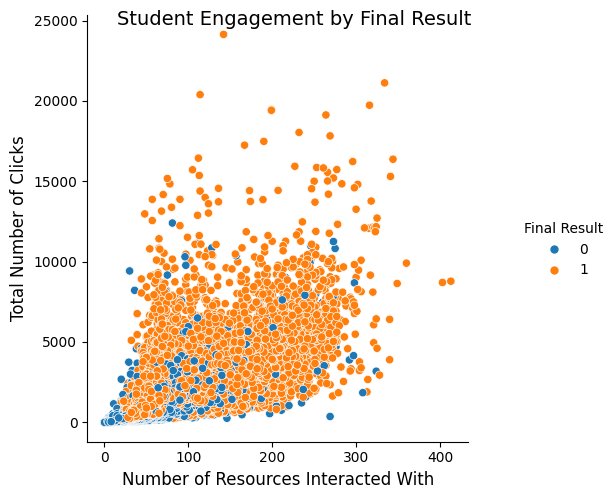

In [59]:
plot=sns.relplot(x='interaction', y='sum_clicks', hue='final_result_binary', data=data)
plot.set_axis_labels("Number of Resources Interacted With","Total Number of Clicks", fontsize=12)
plot.fig.suptitle("Student Engagement by Final Result", fontsize=14)
plot._legend.set_title("Final Result")
plt.show()

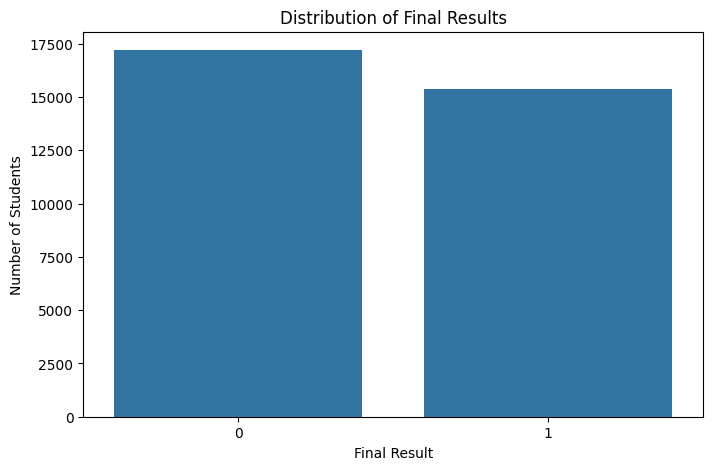

In [24]:
# Distribution of Final Results
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(x='final_result_binary', data=data, order=data['final_result_binary'].value_counts().index)
plt.title("Distribution of Final Results")
plt.xlabel("Final Result")
plt.ylabel("Number of Students")
plt.show()

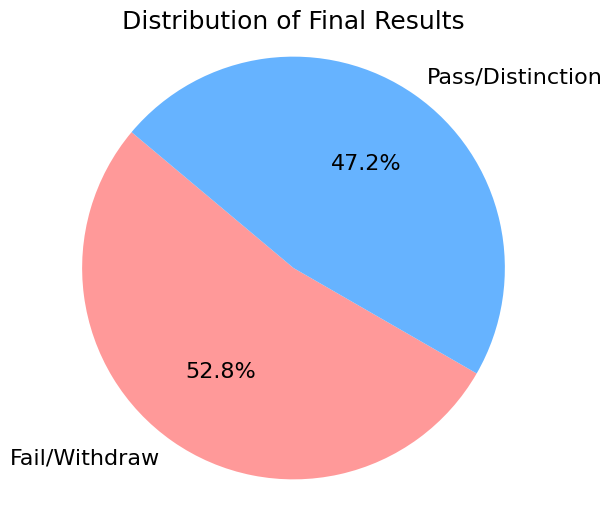

In [25]:
# Count values
result_counts = data['final_result_binary'].value_counts()

# Transform the variable so that appears 0/1
labels = ['Fail/Withdraw', 'Pass/Distinction']
sizes = [result_counts[0], result_counts[1]]
colors = ['#ff9999','#66b3ff']

# Create plot
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, textprops={'fontsize': 12})
plt.title("Distribution of Final Results",fontsize=14)
plt.axis('equal')  # Para que sea un círculo perfecto
plt.show()


<Figure size 1000x600 with 0 Axes>

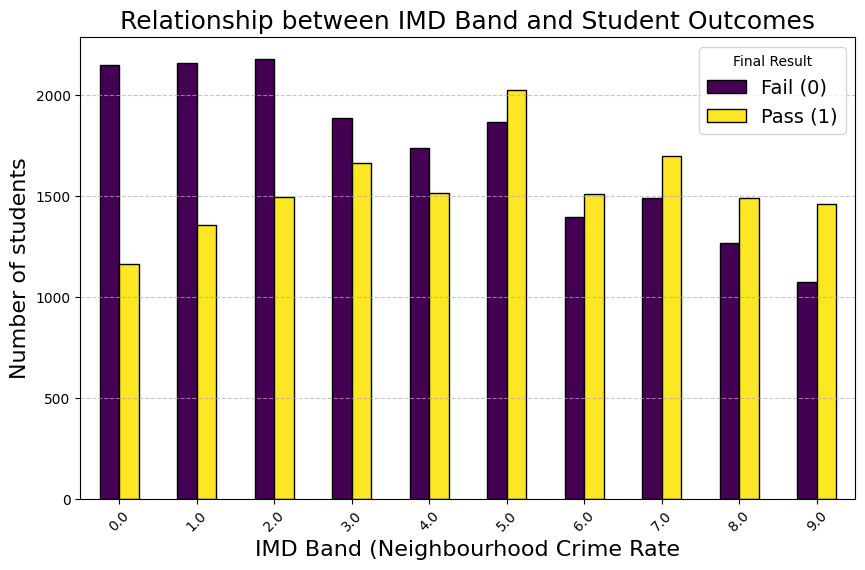

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the students by 'imd_band_encoded' and 'final_result_binary'
imd_final_counts = data.groupby(['imd_band_encoded', 'final_result_binary']).size().unstack()

# Plot this information with a clustered bar chart
plt.figure(figsize=(10, 6))
imd_final_counts.plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')

# Create the visual
plt.xlabel("IMD Band (Neighbourhood Crime Rate", fontsize=14)
plt.ylabel("Number of students", fontsize=12)
plt.title("Relationship between IMD Band and Student Outcomes", fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas para mejor lectura
plt.legend(title="Final Result", labels=["Fail (0)", "Pass (1)"], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar una rejilla ligera

# Mostrar el gráfico
plt.show()

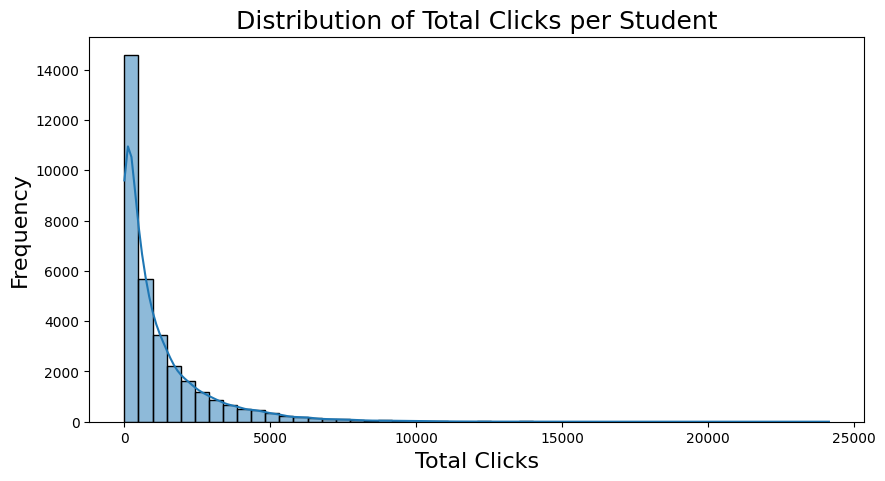

In [27]:
#  Distribution of Student Clicks
plt.figure(figsize=(10,5))
sns.histplot(data['sum_clicks'], bins=50, kde=True)
plt.title("Distribution of Total Clicks per Student", fontsize=14)
plt.xlabel("Total Clicks", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

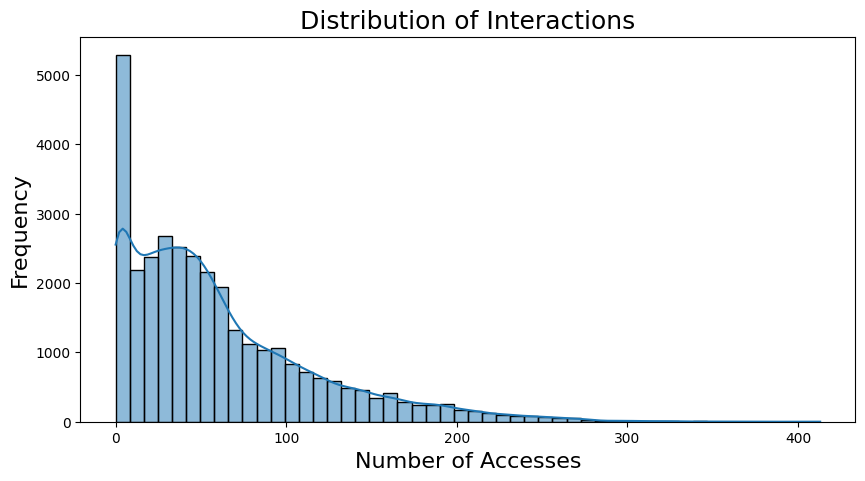

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(data['interaction'], bins=50, kde=True)
plt.title("Distribution of Interactions", fontsize=14)
plt.xlabel("Number of Accesses", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

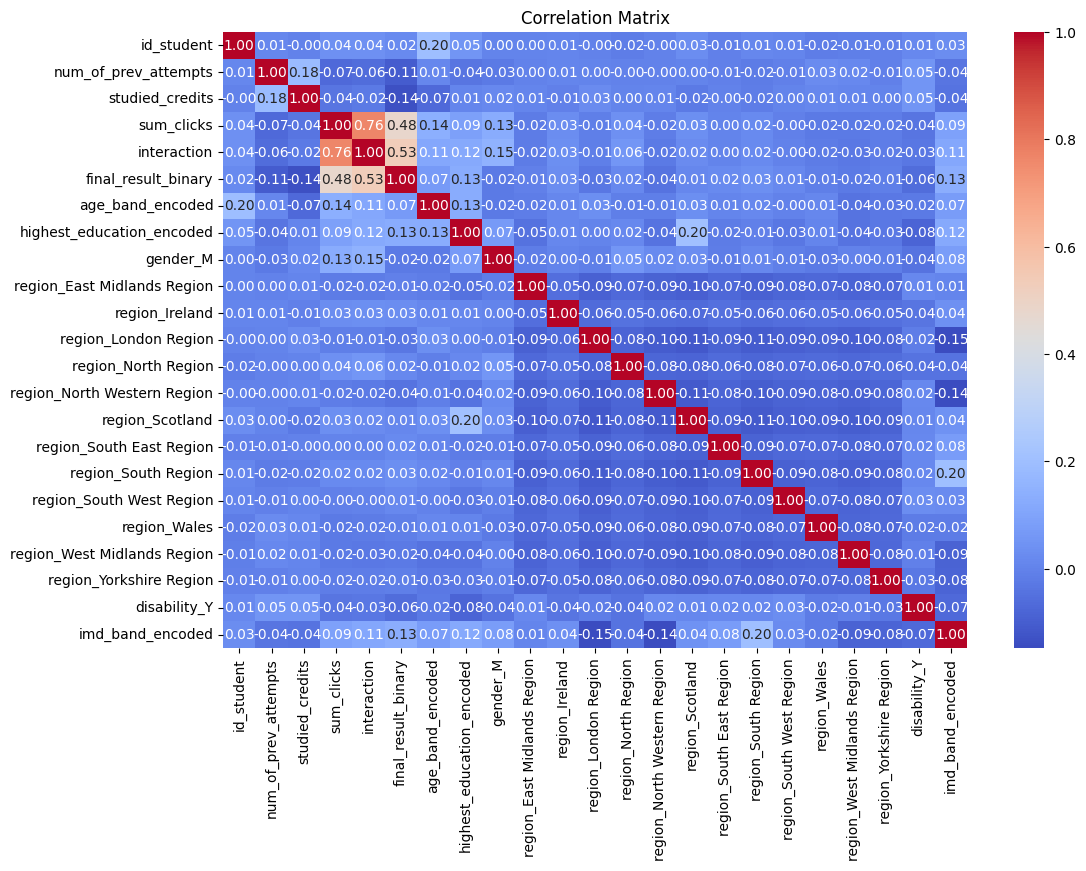

In [29]:
plt.figure(figsize=(12,8))
numeric_data = data.select_dtypes(include=['number'])  # Selecciona solo columnas numéricas
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

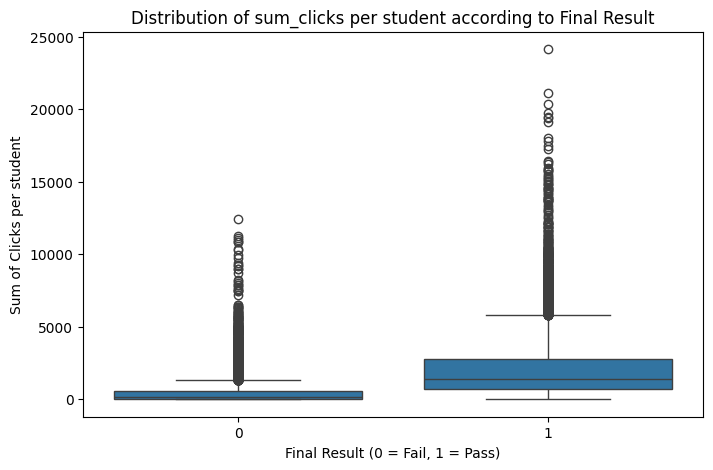

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data['final_result_binary'], y=data['sum_clicks'])
plt.xlabel("Final Result (0 = Fail, 1 = Pass)")
plt.ylabel("Sum of Clicks per student")
plt.title("Distribution of sum_clicks per student according to Final Result")
plt.show()

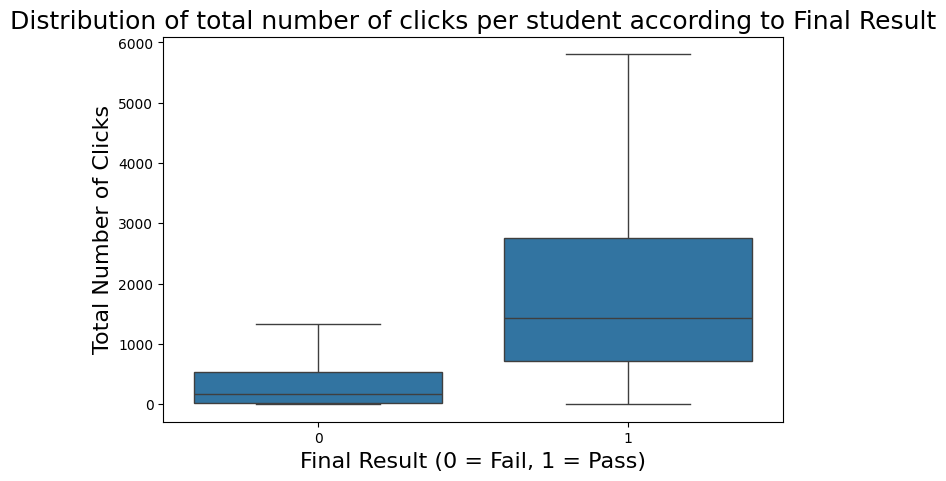

In [31]:
# Boxplot without outliers
plt.figure(figsize=(8,5))
sns.boxplot(x=data['final_result_binary'], y=data['sum_clicks'], showfliers=False)

# Create visual
plt.xlabel("Final Result (0 = Fail, 1 = Pass)", fontsize=14)
plt.ylabel("Total Number of Clicks", fontsize=14)
plt.title("Distribution of total number of clicks per student according to Final Result", fontsize=14)


plt.show()


Finally, all the variables were normalized, as neural networks require input features to be on the same scale. We used MinMaxScaler to rescale all values between 0 and 1.

In [32]:
X = data.drop(columns=['id_student', 'final_result_binary']).select_dtypes(include=['number'])
y = data['final_result_binary'].astype('float32')  # Ensure correct type



In [33]:
X

,num_of_prev_attempts,studied_credits,sum_clicks,interaction,age_band_encoded,highest_education_encoded,gender_M,region_East Midlands Region,region_Ireland,region_London Region,...,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_Y,imd_band_encoded
0,0,240,934.0,55.0,2.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1,0,60,1435.0,84.0,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0,60,281.0,22.0,1.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,0,60,2158.0,82.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0,60,1034.0,66.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,0,30,41.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
32589,0,30,893.0,50.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
32590,0,30,312.0,28.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
32591,0,30,275.0,17.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [34]:
column_names = X.columns.tolist()
print(column_names)

['num_of_prev_attempts', 'studied_credits', 'sum_clicks', 'interaction', 'age_band_encoded', 'highest_education_encoded', 'gender_M', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'disability_Y', 'imd_band_encoded']


In [35]:
pd.DataFrame(column_names).to_csv("X_columns.csv", index=False, header=False)

In [36]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [37]:
X

array([[0.        , 0.336     , 0.03869257, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.048     , 0.05944737, ..., 0.        , 0.        ,
        0.22222222],
       [0.        , 0.048     , 0.01164091, ..., 0.        , 1.        ,
        0.33333333],
       ...,
       [0.        , 0.        , 0.01292514, ..., 0.        , 1.        ,
        0.22222222],
       [0.        , 0.        , 0.01139235, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.02551887, ..., 1.        , 0.        ,
        0.55555556]])

**Model Training**

In [38]:
# Split into training (75%) and test (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
# Guardar X_train e y_train en un archivo CSV
X_train_df = pd.DataFrame(X_train)  # Si X_train es un array o DataFrame
y_train_df = pd.DataFrame(y_train)  # Si y_train es un array o DataFrame

# Guardar en CSV
X_train_df.to_csv('X_train.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)


In [40]:
# Guardar X_train e y_train en un archivo CSV
x_test_df = pd.DataFrame(X_test)  # Si X_train es un array o DataFrame
y_test_df = pd.DataFrame(y_test)  # Si y_train es un array o DataFrame

# Guardar en CSV
x_test_df.to_csv('x_test.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

To adjust the hyperparameters of the network such as the number of neurons in the hidden layers or the activation functions, a 5-fold cross validation procedure was carried in the training set. The mean accuracy is then used to compare the different ANN topologies.

In [41]:
# Configuración de la validación cruzada (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

The distribution of the target variable y_train was checked to identify class imbalance. The percentage of 0s and 1s was calculated in order to assess the baseline performance of the majority class rule, which any predictive model must outperform.

In [42]:
# Calcular el porcentaje de cada clase en y_train
class_counts = y_train.value_counts(normalize=True) * 100

# Mostrar los porcentajes
print("Distribución de clases en y_train (%):")
print(class_counts)

Distribución de clases en y_train (%):
final_result_binary
0.0    52.810506
1.0    47.189494
Name: proportion, dtype: float64


The majority class rule reveals that the proportion of students who fail is higher, indicating that most observations in the training set belong to the negative class.


**MODEL 1** Obtaining hyperparametrs

We first created a model **without cross-validation** to test the optimal architecture proposed in the reference article. This simple model includes **one hidden layer with 15 neurons**, uses the **sigmoid activation function** in both the hidden and output layers, and applies **binary cross-entropy** as the loss function. We used this initial setup to observe how accuracy changes with the number of epochs, in order to determine the appropriate training duration.


In [43]:
# Define a neural network predictive model
simple_model = Sequential([
    Dense(15, activation='sigmoid', input_shape=(X_train.shape[1],)),  # Capa oculta con 15 neuronas y sigmoide
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide
])

# Compile model: We compile the model to define how it learns, by specifying the loss function, optimizer, and evaluation metric.
simple_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# Train the model and create model history
history = simple_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5769 - loss: 0.6826 - val_accuracy: 0.7160 - val_loss: 0.6312
Epoch 2/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7215 - loss: 0.6110 - val_accuracy: 0.7608 - val_loss: 0.5545
Epoch 3/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7612 - loss: 0.5375 - val_accuracy: 0.7748 - val_loss: 0.5007
Epoch 4/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7749 - loss: 0.4934 - val_accuracy: 0.7789 - val_loss: 0.4765
Epoch 5/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7823 - loss: 0.4709 - val_accuracy: 0.7883 - val_loss: 0.4677
Epoch 6/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7853 - loss: 0.4623 - val_accuracy: 0.7893 - val_loss: 0.4644
Epoch 7/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7908 - loss: 0.4568 - val_accuracy: 0.7852 - val_loss: 0.4624
Epoch 8/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7933 - loss: 0.4515 - val_accu

In [45]:
loss, simple_model_accuracy = simple_model.evaluate(X_test, y_test, verbose = False)
print(f'Model Accuracy = {simple_model_accuracy: .3f}')

Model Accuracy =  0.802


In [46]:
# Define majority class rule
majority_class_percentage = y_train.value_counts(normalize=True).max() * 100


# Show results
print(f"📊 Majority class rule: {majority_class_percentage:.2f}%")
print(f"🎯 Accuracy of the model in the test set: {simple_model_accuracy * 100:.2f}%")

# Comparison
if simple_model_accuracy * 100 > majority_class_percentage:
    print("✅ The model outperforms the majority class rule")
else:
    print("⚠️ The model does not surpass the majority class rule")

📊 Majority class rule: 52.81%
🎯 Accuracy of the model in the test set: 80.17%
✅ The model outperforms the majority class rule


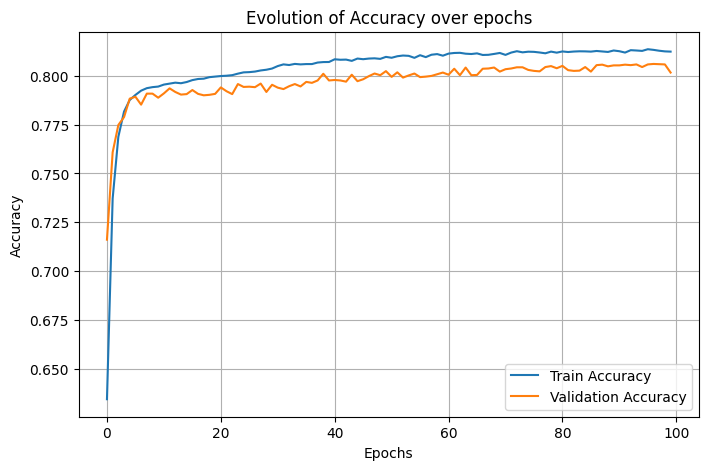

In [47]:
# Evolution of epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Evolution of Accuracy over epochs")
plt.legend()
plt.grid(True)
plt.show()

This graph suggests that, from around 30-40 epochs onward, accuracy stabilizes at approximately 80% for both training and validation. This indicates that the model has learned enough and further training does not lead to significant improvement. Moreover, the training and validation curves remain close, suggesting good generalization. A large gap between them would indicate overfitting. Therefore, based on these results, the model stabilizes after 30-40 epochs. We can use 40 epochs, as extending to 100 does not offer substantial additional benefit.

**MODEL 2** Evaluate a model with cross validation to obtain the best combination of hyperparametrs, that result in the highest accuracy of the model

A first study was carried with a single hidden layer with up to 30 neurons and the activation function introduced previously. The results are given inFig. 3.

In [48]:
# Creat ANN with one hidden layer
def build_model(hidden_neurons, activation):
    model = Sequential([
        Dense(hidden_neurons, activation=activation, input_shape=(X_train.shape[1],)),
        Dense(1, activation='sigmoid')  # 1 salidas (probabilidad de fail/pass)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [49]:
# Define hyperparameters
hidden_layer_options = [1, 5, 10, 15, 20, 25, 30,40,50]
activation_functions = ['softplus', 'sigmoid', 'tanh']  # 'sigmoid' because is a classification problem
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Dictionary to store the results of each activation function, to allow subsequent comparisons between different combinations
results = {activation: [] for activation in activation_functions}

In [50]:
best_score = 0
best_params = (None, None)

results = []

# Evaluate the number of neurons with each activation function
for activation in activation_functions:
    for hidden_neurons in hidden_layer_options:
        fold_scores = []

        y_train = np.array(y_train)

        # Cross validation process
        for train_index, val_index in kf.split(X_train):
            X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
            y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

            model = build_model(hidden_neurons, activation)
            model.fit(X_fold_train, y_fold_train, epochs=40, batch_size=32, verbose=0)

            _, accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)
            fold_scores.append(accuracy)

        mean_accuracy = np.mean(fold_scores)

        results.append({
    'Neurons': hidden_neurons,
    'Activation': activation,
    'Accuracy': mean_accuracy
})


        # Store the optimal model
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_params = (hidden_neurons, activation)

        print(f"Neurons: {hidden_neurons}, Activation: {activation}, Accuracy: {mean_accuracy:.4f}")

print(f"\n✅ Best model: {best_params[0]} neurons, Activation function: {best_params[1]}, Accuracy: {best_score:.4f}")

Neurons: 1, Activation: softplus, Accuracy: 0.7960
Neurons: 5, Activation: softplus, Accuracy: 0.8021
Neurons: 10, Activation: softplus, Accuracy: 0.8025
Neurons: 15, Activation: softplus, Accuracy: 0.8085
Neurons: 20, Activation: softplus, Accuracy: 0.8067
Neurons: 25, Activation: softplus, Accuracy: 0.8060
Neurons: 30, Activation: softplus, Accuracy: 0.8027
Neurons: 40, Activation: softplus, Accuracy: 0.8048
Neurons: 50, Activation: softplus, Accuracy: 0.8060
Neurons: 1, Activation: sigmoid, Accuracy: 0.8054
Neurons: 5, Activation: sigmoid, Accuracy: 0.8040
Neurons: 10, Activation: sigmoid, Accuracy: 0.8052
Neurons: 15, Activation: sigmoid, Accuracy: 0.8036
Neurons: 20, Activation: sigmoid, Accuracy: 0.8035
Neurons: 25, Activation: sigmoid, Accuracy: 0.8049
Neurons: 30, Activation: sigmoid, Accuracy: 0.8038
Neurons: 40, Activation: sigmoid, Accuracy: 0.8030
Neurons: 50, Activation: sigmoid, Accuracy: 0.8024
Neurons: 1, Activation: tanh, Accuracy: 0.8074
Neurons: 5, Activation: tanh, 

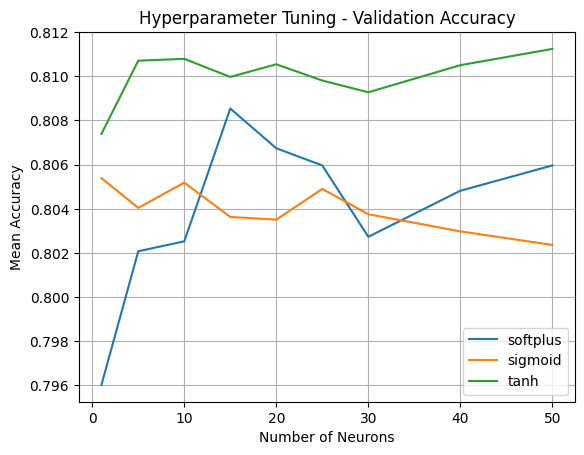

In [51]:
df_results = pd.DataFrame(results)
for act in activation_functions:
    subset = df_results[df_results['Activation'] == act]
    plt.plot(subset['Neurons'], subset['Accuracy'], label=act)

plt.xlabel("Number of Neurons")
plt.ylabel("Mean Accuracy")
plt.title("Hyperparameter Tuning - Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**FINAL MODEL** Final model with the hyperparametrs that result in the model with best accuracy

In [52]:
# Define a neural network with the optimal combination of hyperparametrs
final_model = Sequential([
    Dense(50, activation='tanh', input_shape=(X_train.shape[1],)),  # Best hiperparámetros
    Dense(1, activation='sigmoid')
])

final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the validation set
history = final_model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_data=(X_test, y_test))


# Evaluation with test set
loss, final_accuracy = final_model.evaluate(X_test, y_test, verbose=False)
print(f'Model Accuracy = {final_accuracy:.3f}')

Epoch 1/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7067 - loss: 0.5897 - val_accuracy: 0.7832 - val_loss: 0.4724
Epoch 2/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7850 - loss: 0.4672 - val_accuracy: 0.7781 - val_loss: 0.4704
Epoch 3/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7892 - loss: 0.4627 - val_accuracy: 0.7800 - val_loss: 0.4705
Epoch 4/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7928 - loss: 0.4572 - val_accuracy: 0.7891 - val_loss: 0.4665
Epoch 5/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7924 - loss: 0.4618 - val_accuracy: 0.7854 - val_loss: 0.4661
Epoch 6/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7957 - loss: 0.4552 - val_accuracy: 0.7918 - val_loss: 0.4667
Epoch 7/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7955 - loss: 0.4492 - val_accuracy: 0.7940 - val_loss: 0.4661
Epoch 8/40
764/764 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7949 - loss: 0.4620 - val_accuracy: 0.

Store the final model

In [53]:
final_model.export("my_model_saved")

Saved artifact at 'my_model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21), dtype=tf.float32, name='keras_tensor_408')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135411162586704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135411162594576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135411162593616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135411162593232: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [54]:
final_model.save('my_model.keras')

In [55]:
# Majority class Rule
majority_class_percentage = pd.Series(y_train).value_counts(normalize=True).max() * 100

print(f"📊 Majority class rule: {majority_class_percentage:.2f}%")
print(f"🎯 Accuracy of the final model: {final_accuracy * 100:.2f}%")

if final_accuracy * 100 > majority_class_percentage:
    print("✅ The model outperforms the majority class rule")
else:
    print("⚠️ The model does not surpass the majority class rule")

📊 Majority class rule: 52.81%
🎯 Accuracy of the final model: 80.41%
✅ The model outperforms the majority class rule


In [56]:
# Predictions of the final model (already trained)
y_pred_probs = final_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Obatain metrics
report = classification_report(y_test, y_pred, output_dict=True, target_names=["Fail", "Pass"])
df_report = pd.DataFrame(report).T

# Select columns
df_table = df_report.loc[["Fail", "Pass", "weighted avg"], ["precision", "recall", "f1-score"]]
df_table.index = ["Fail", "Pass", "Average"]
df_table = df_table.round(3)

# Print table of metrics
print(df_table)

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
         precision  recall  f1-score
Fail         0.825   0.797     0.811
Pass         0.782   0.812     0.797
Average      0.805   0.804     0.804


## History Plots

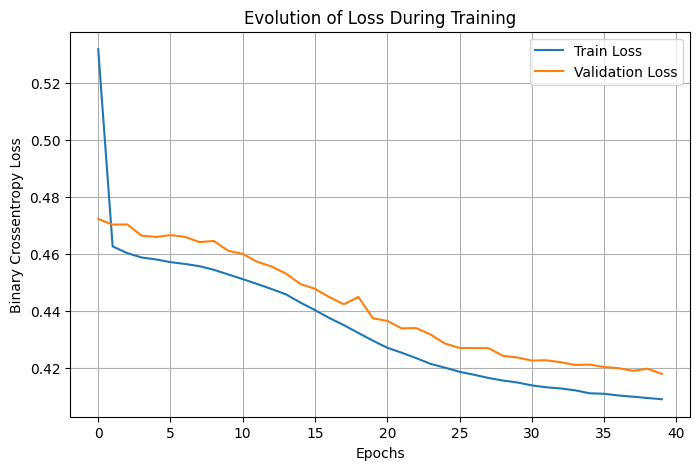

In [57]:
# Visualization of the evolution of the loss function during training
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolution of Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()
